In [21]:
%pip install scikit-learn xgboost imbalanced-learn

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# df_trn = pd.read_csv("../data/guiDataCleanInfill0Treino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanInfill0Teste.csv")

# df_trn = pd.read_csv("../data/guiDataCleanKNNTreino.csv")
# df_tst = pd.read_csv("../data/guiDataCleanKNNTeste.csv")

df_trn = pd.read_csv("../data/guiDataCleanMaxDataTreino.csv")
df_tst = pd.read_csv("../data/guiDataCleanMaxDataTeste.csv")

In [22]:
# Dividir X e y
X_train, y_train = df_trn.drop('nr_abandono', axis=1), df_trn['nr_abandono']
X_test, y_test = df_tst.drop('nr_abandono', axis=1), df_tst['nr_abandono']

# SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)

#avaliar o modelo e mostrar a acurácia
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

Acurácia: 0.91
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        32
           1       1.00      0.71      0.83        14

    accuracy                           0.91        46
   macro avg       0.94      0.86      0.89        46
weighted avg       0.92      0.91      0.91        46

Matriz de Confusão:
[[32  0]
 [ 4 10]]


In [24]:
#descobrir os melhores hiperparâmetros para random forest
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_random = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_resampled, y_train_resampled)
print("Melhores hiperparâmetros encontrados:")
print(rf_random.best_params_)

# Treinar o modelo com os melhores hiperparâmetros
best_rf_model = rf_random.best_estimator_
best_rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_best = best_rf_model.predict(X_test)

# Avaliar o modelo com os melhores hiperparâmetros
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Acurácia com os melhores hiperparâmetros: {accuracy_best:.2f}")
print("Relatório de Classificação com os melhores hiperparâmetros:")
print(classification_report(y_test, y_pred_best))

# Matriz de Confusão com os melhores hiperparâmetros
print("Matriz de Confusão com os melhores hiperparâmetros:")
print(confusion_matrix(y_test, y_pred_best))



Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores hiperparâmetros encontrados:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': False}
Acurácia com os melhores hiperparâmetros: 0.93
Relatório de Classificação com os melhores hiperparâmetros:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.79      0.88        14

    accuracy                           0.93        46
   macro avg       0.96      0.89      0.92        46
weighted avg       0.94      0.93      0.93        46

Matriz de Confusão com os melhores hiperparâmetros:
[[32  0]
 [ 3 11]]


In [25]:
#verificar se o modelo está overfitting
from sklearn.metrics import roc_auc_score, roc_curve
y_train_pred = best_rf_model.predict_proba(X_train_resampled)[:, 1]
y_test_pred = best_rf_model.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train_resampled, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)
print(f"AUC no conjunto de treino: {train_auc:.2f}")
print(f"AUC no conjunto de teste: {test_auc:.2f}")

# salvar o modelo treinado
import joblib
joblib.dump(best_rf_model, 'random_max_data.pkl')


AUC no conjunto de treino: 1.00
AUC no conjunto de teste: 0.99


['random_max_data.pkl']

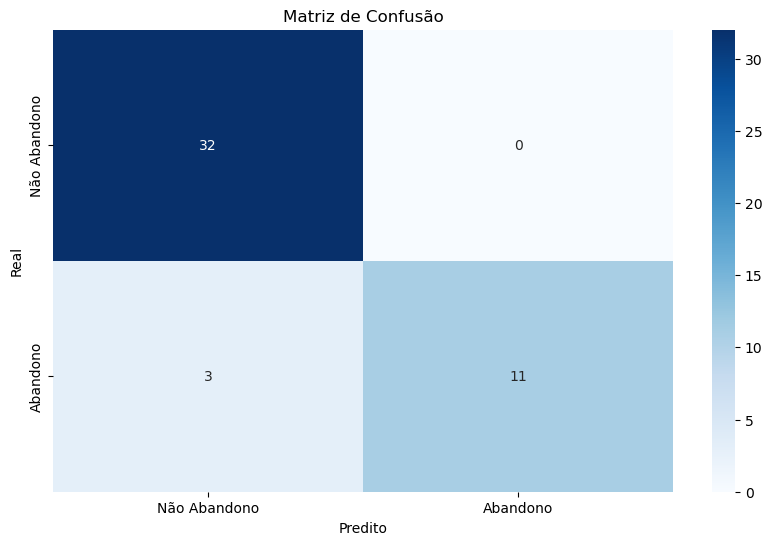

In [26]:
#visualizar os resultados
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar a matriz de confusão
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues', xticklabels=['Não Abandono', 'Abandono'], yticklabels=['Não Abandono', 'Abandono'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()


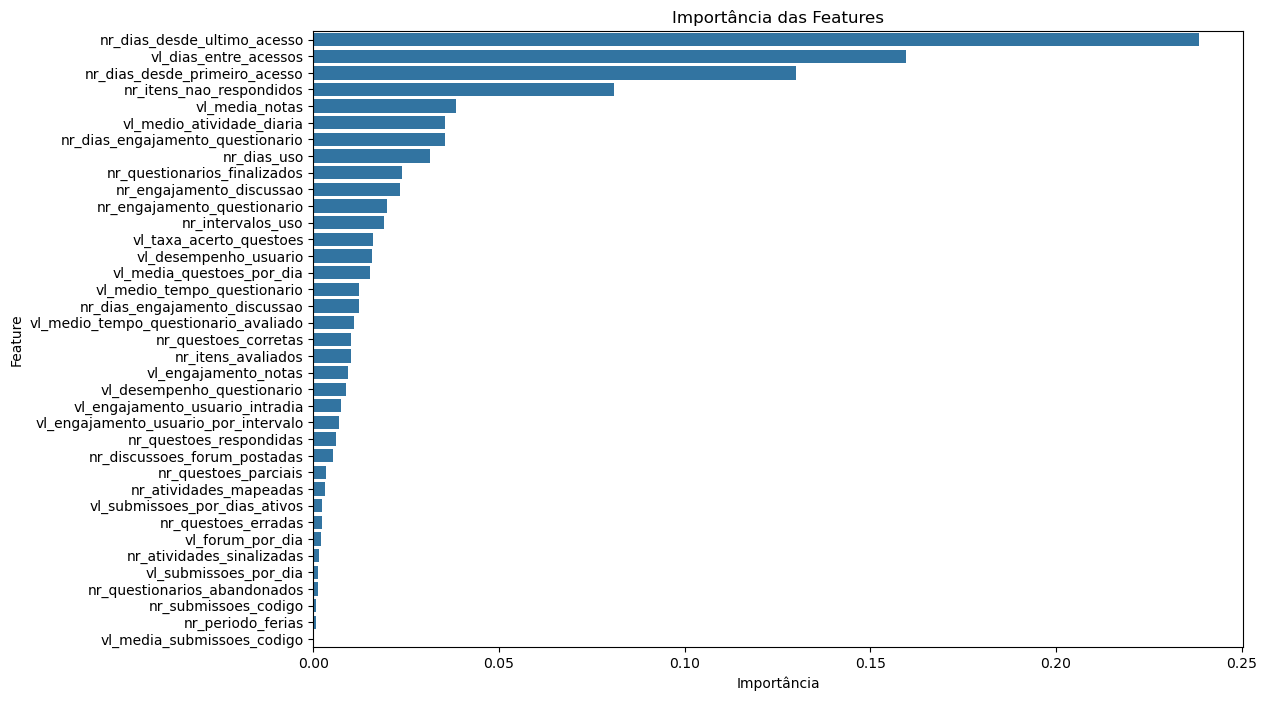

In [27]:
# visualizar importancia das features com nomes
importances = best_rf_model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para as importâncias
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar o DataFrame por importância
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plotar as importâncias das features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()


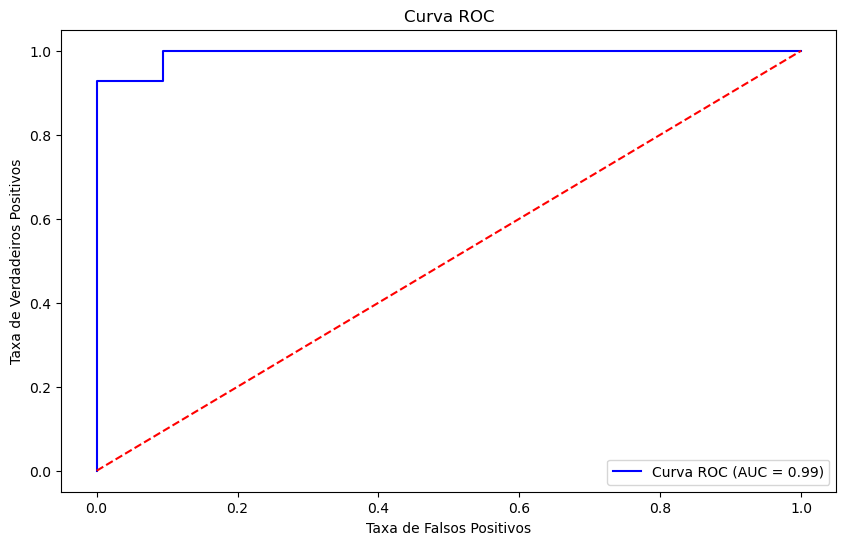

In [28]:
# visualizar a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='Curva ROC (AUC = {:.2f})'.format(test_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend()
plt.show()


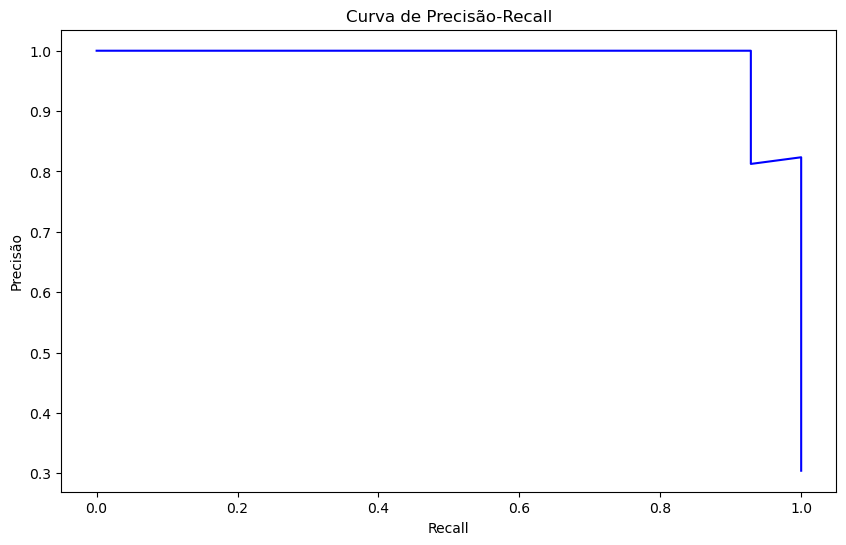

In [29]:
# Plotar a curva de precisão-recall
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue')
plt.title('Curva de Precisão-Recall')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.show()

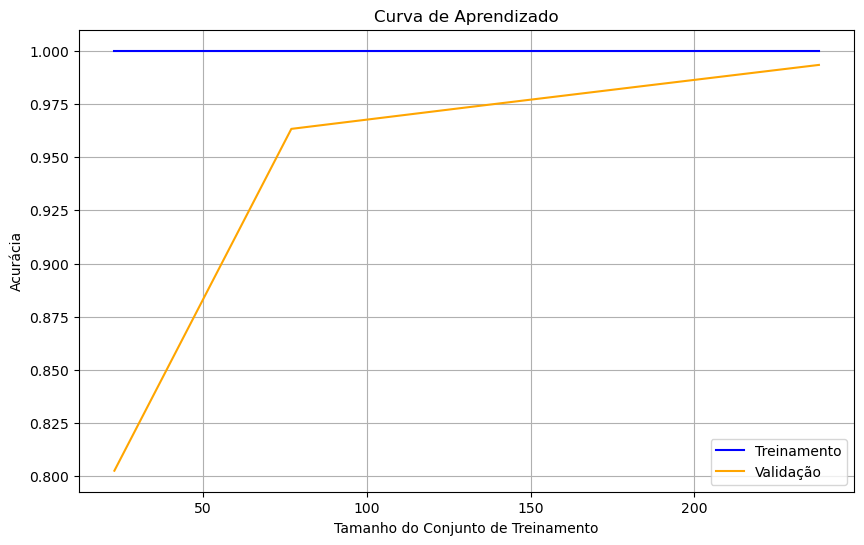

In [30]:
# Plotar a curva de aprendizado com treinamento e validação
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_rf_model, X_train_resampled, y_train_resampled, cv=5, n_jobs=-1)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Treinamento', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validação', color='orange')
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Acurácia')
plt.legend()
plt.grid()
plt.show()


In [31]:
# salvar metricas de desempenho para comparação futura, recall, roc_auc, precision, f1
metrics = {
    'accuracy': accuracy,
    'roc_auc': test_auc,
    'precision': precision.mean(),
    'recall': recall.mean(),
    'f1_score': (2 * (precision.mean() * recall.mean())) / (precision.mean() + recall.mean())
}
import json
with open('metrics_max_data_RandomForest.json', 'w') as f:
    json.dump(metrics, f)
